In [1]:
!pip install efficientnet

import cv2
import os
import numpy as np
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from efficientnet.keras import EfficientNetB5
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

# Define your custom callback
class MyCallback(Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.batches = batches
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch

        self.count = 0
        self.stop_count = 0
        self.best_epoch = 1
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))
        self.highest_tracc = 0.0
        self.lowest_vloss = np.inf
        self.best_weights = self.model.get_weights()
        self.initial_weights = self.model.get_weights()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.batches == 0 and epoch > 0:
            tr_acc = logs.get('accuracy')
            v_loss = logs.get('val_loss')

            if tr_acc > self.highest_tracc:
                self.highest_tracc = tr_acc

            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1
                self.best_weights = self.model.get_weights()
                self.count = 0
            else:
                self.count += 1

            if tr_acc >= self.threshold:
                self.ask_epoch -= 1

            if self.count == self.patience and self.ask_epoch > 0:
                print("\nEpoch %d: Accuracy threshold reached. Decreasing learning rate." % (epoch + 1))
                old_lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
                new_lr = old_lr * self.factor
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
                print("Learning rate decreased from %f to %f" % (old_lr, new_lr))
                self.count = 0

            if self.count == self.patience and self.ask_epoch == 0:
                self.stop_count += 1
                if self.stop_count == self.stop_patience:
                    print("\nTraining stopped at epoch %d" % (epoch + 1))
                    self.model.stop_training = True
                else:
                    print("\nEpoch %d: Learning rate adjustment limit reached. Restoring best weights." % (epoch + 1))
                    self.model.set_weights(self.best_weights)
                    self.count = 0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.1 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
# Set the data path and categories
data_path = '/kaggle/input/kao-1500/MedicalExpert-I'
categories = os.listdir(data_path)
labels = [i for i in range(len(categories))]

label_dict = dict(zip(categories, labels))

img_size = 256
data = []
label = []

# Load the images and labels from the train folder
for category in categories:
    folder_path = os.path.join(data_path, category)
    img_names = os.listdir(folder_path)

    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        try:
            resized = cv2.resize(img, (img_size, img_size))
            data.append(resized)
            label.append(label_dict[category])
        except Exception as e:
            print('Exception:', e)

data = np.array(data) / 255.0
label = np.array(label)
new_label = np_utils.to_categorical(label)

# Split the data into train, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(data, new_label, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [3]:
# Construct the EfficientNetB3 model
base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3), pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(len(categories), activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

115515256/115515256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b5 (Functional  (None, 2048)             28513520  
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                       

In [4]:
# Set up a checkpoint to save the best model
checkpoint = ModelCheckpoint('/kaggle/working/model2.h5', monitor='val_accuracy', save_best_only=True, mode='max',
                             verbose=1)

# Set up the custom callback
my_callback = MyCallback(model=model, patience=4, stop_patience=10, threshold=0.95, factor=0.1, batches=10, epochs=100,
                         ask_epoch=10)

# Train the model
history = model.fit(x_train, y_train, batch_size=16, epochs=100, validation_data=(x_val, y_val), callbacks=[checkpoint, my_callback])

Epoch 1/100


2023-06-30 07:01:37.851098: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnet-b5/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


75/75 [==============================] - ETA: 0s - loss: 9.6029 - accuracy: 0.4192
Epoch 1: val_accuracy improved from -inf to 0.31061, saving model to /kaggle/working/model2.h5
75/75 [==============================] - 160s 682ms/step - loss: 9.6029 - accuracy: 0.4192 - val_loss: 11.4359 - val_accuracy: 0.3106
Epoch 2/100
75/75 [==============================] - ETA: 0s - loss: 8.2195 - accuracy: 0.6061
Epoch 2: val_accuracy improved from 0.31061 to 0.43182, saving model to /kaggle/working/model2.h5
75/75 [==============================] - 47s 621ms/step - loss: 8.2195 - accuracy: 0.6061 - val_loss: 9.2541 - val_accuracy: 0.4318
Epoch 3/100
75/75 [==============================] - ETA: 0s - loss: 7.4206 - accuracy: 0.6305
Epoch 3: val_accuracy improved from 0.43182 to 0.43939, saving model to /kaggle/working/model2.h5
75/75 [==============================] - 47s 630ms/step - loss: 7.4206 - accuracy: 0.6305 - val_loss: 9.4758 - val_accuracy: 0.4394
Epoch 4/100
75/75 [===================

In [5]:
# Load the best weights
model.load_weights('/kaggle/working/model2.h5')


In [7]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)



11/11 [==============================] - 5s 289ms/step - loss: 0.9105 - accuracy: 0.8091
Test Loss: 0.9105031490325928
Test Accuracy: 0.8090909123420715


11/11 [==============================] - 6s 226ms/step
Confusion Matrix:
[[83  0  2  5 15]
 [ 0 40  6  3  1]
 [ 2  0 29  1  0]
 [13  0  1 30  4]
 [ 8  0  0  2 85]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.79      0.79       105
           1       1.00      0.80      0.89        50
           2       0.76      0.91      0.83        32
           3       0.73      0.62      0.67        48
           4       0.81      0.89      0.85        95

    accuracy                           0.81       330
   macro avg       0.82      0.80      0.81       330
weighted avg       0.81      0.81      0.81       330



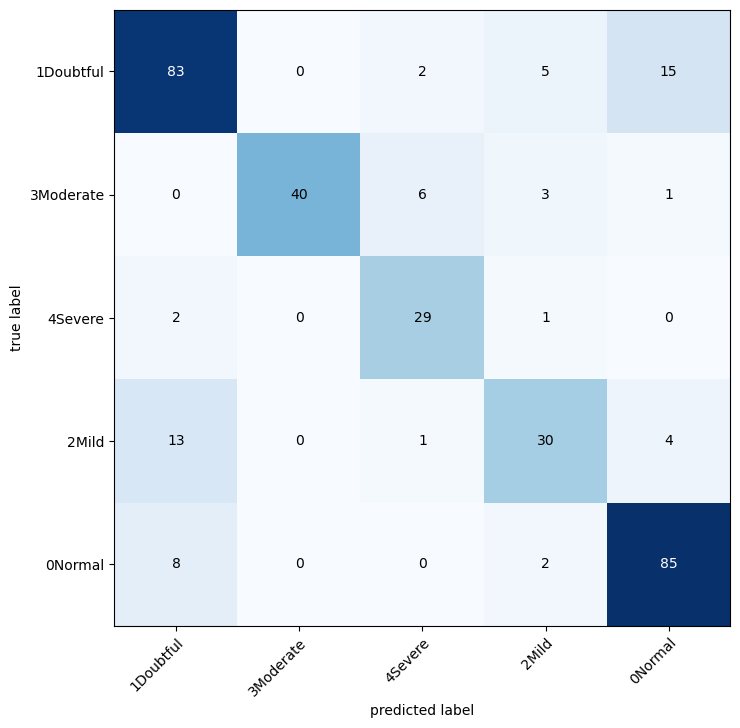

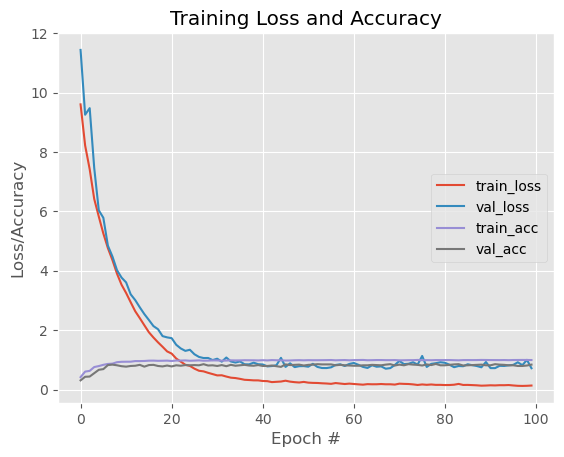

In [8]:
# Generate predictions
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)

# Generate confusion matrix and classification report
cm = confusion_matrix(np.argmax(y_test, axis=1), predicted_labels)
print("Confusion Matrix:")
print(cm)

cr = classification_report(np.argmax(y_test, axis=1), predicted_labels)
print("Classification Report:")
print(cr)

# Plot confusion matrix
plot_confusion_matrix(conf_mat=cm, figsize=(8, 8), class_names=categories)
plt.show()

# Plot the training loss and accuracy
N = len(history.history['loss'])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("EfficientNet_Model")